# Project EA P2

# Simulations of the model without telomerase

## References:
1. The asymmetry of telomere replication contributes to replicative senescence heterogeneity
2. The Length of the Shortest Telomere as the Major Determinant of the Onset of Replicative Senescence

We have two goals here: 
+ to investigate some of the results found in [1], and see if we can find them back, by simulation means.
+ to check the theoretical computations in our report, which aimed at finding theoretical values for the mean and variance of the number of cellular divisions before senescence.

In [17]:
from numpy import random as npr
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as scs

## Reconstructing the stationary distribution with telomerase

This stationary distribution is taken as a starting point for the evolution without telomerase.

In [3]:
# Parameters from the model - the parameters values are taken either from [1] or from the other notebook
s = 3.5
p = 0.026
beta = 0.0236
L_0 = 101
n = 1700 

In [4]:
# gives the probability of action of telomerase as a function of telomere length
def P(L, L_0, beta):
    if L >= L_0:
        return 1./(1 + beta*(L-L_0))
    else:
        return 1

# useful for quick computation
def precompute_arrays(L_0, beta):
    geom = np.array([p*(1-p)**k for k in range(n)])
    probas = np.array([P(k, L_0, beta) for k in range(n)])
    return geom, probas

# one iteration from the distribution computation
def iter_distr(pi, L_0, beta, geom, probas):
    new_pi = np.array([0.]*len(pi))
    for i in range(len(pi)-7):
        pi_i = pi[i+7]*(1-P(i+7, L_0, beta)) + np.sum(geom[:int(i/2.+3.5)]*probas[i+5::-2]*pi[i+5::-2])
        new_pi[i] = pi_i
    for i in range(len(pi)-7, len(pi)):
        new_pi[i] = 0.
    return new_pi

# Many iterations for the distribution computation + graph plot + skewness and mode computation
def evol_distr(n_iter, pi, L_0, beta, verbose=True):
    geom, probas = precompute_arrays(L_0, beta)
    pi2 = np.copy(pi)
    for k in range(n_iter):
        pi2 = iter_distr(pi2, L_0, beta, geom, probas)
        pi2 = pi2 / np.sum(pi2)
    
    r = np.array(range(n))/2
    if verbose:
        plt.figure()
        plt.plot(r, pi2)
        plt.show()
    mode = r[np.argmax(pi2)]
    mean = np.sum(r*pi2)
    std = np.sqrt(np.sum(r**2*pi2)-mean**2)
    skewness = np.sum(((r-mean)/std)**3*pi2)
    
    if verbose:
        print('Mode: ' + str(mode))
        print('Skewness: ' + str(skewness))
    return pi2, mode, skewness

In [7]:
# Initialization
pi = np.array([0.]*n)
for k in range(L_0, 2*L_0):
    pi[k] = 1./L_0

Stationary distribution (one thousand iteration, takes a dozen seconds):


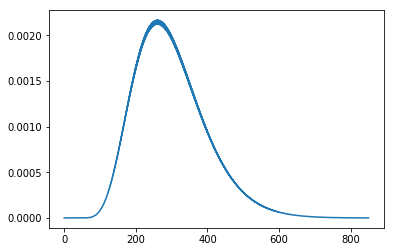

Mode: 260.5
Skewness: 0.729789529549
Cumulated sum of the stationary distribution:


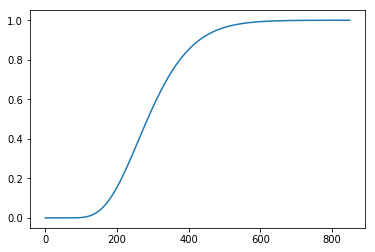

In [9]:
n_iter = 1000
print('Stationary distribution (one thousand iteration, takes a dozen seconds):')
pi_final, m, s = evol_distr(n_iter, pi, L_0, beta)
cdf = np.cumsum(pi_final)
print('Cumulated sum of the stationary distribution:')
plt.plot(np.arange(0, 850, step=0.5), cdf)
plt.show()

## Simulation without telomerase

Here we investigate the results in [1] in Figure 4: four models are compared, which differ by:
+ the type of initialization used: independent founder cells (random), or single founder cell (deterministic)
+ the evolution model used: random or deterministic

For each model, the (coefficient of variation)[https://en.wikipedia.org/wiki/Coefficient_of_variation] is computed. We want to compute this statistical measure here again, and check we obtain coherent results with [1]. We do so for three of the four models investigated in [1]. For all these models, we find a value coherent with [1].

In [27]:
length_senescence = 19    # parameter taken from [1]

In [28]:
# Initialization of the simulation without telomerase : a random variable following the above distribution
def initialization_from_distr():
    u = npr.rand()
    return np.where(cdf>u)[0][0] / 2.

### Asymetric model

In [29]:
# Evolution of the telomere lengths during one cellular division - asymetric model
def evolution(list_lengths):
    permutation = np.arange(32)
    npr.shuffle(permutation)
    new_lengths = [0]*32
    for k in range(32):
        if permutation[k] >= 17:
            new_lengths[k] = list_lengths[k]
        else:
            new_lengths[k] = list_lengths[k] - npr.randint(5, 11)
    return new_lengths

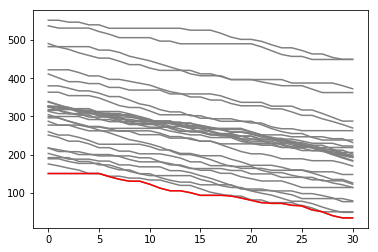

In [30]:
# Example with 32 telomeres and 30 cell divisions. The telomere of minimal length is in red.
T = 30
list_lengths = [initialization_from_distr() for k in range(32)]
big_list = [list_lengths]
for t in range(T):
    list_lengths = evolution(list_lengths)
    big_list.append(list_lengths)
for k in range(32):
    plt.plot(range(T+1), [big_list[i][k] for i in range(T+1)], color='grey')
plt.plot(range(T+1), [min(big_list[i]) for i in range(T+1)], color='red')
plt.show()

### Asymetric model -  deterministic initialization ('single founder cell')

In [55]:
n_exp = 10000
L_finales = []
T_final = []
list_lengths_init = [initialization_from_distr() for k in range(32)]

for exp in range(n_exp):
    T = 0
    list_lengths = list_lengths_init
    longueur = min(list_lengths)
    while longueur > length_senescence:
        T += 1
        list_lengths = evolution(list_lengths)
        longueur = min(list_lengths)
    T_final.append(T)

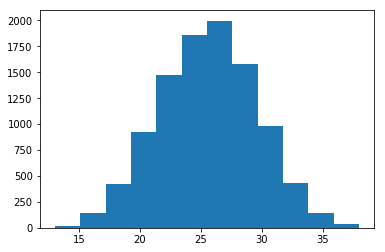

In [56]:
# Histogram of the number of cellular divisions before senescence
plt.hist(T_final, bins=12)
plt.show()

In [57]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
# In [1], they find 0.16 +- 0.05
print(np.std(T_final)/np.mean(T_final))

0.150381950135


### Asymetric model -  random initialization ('independent founder cell')

In [46]:
n_exp = 10000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    list_lengths = [initialisation_from_distr() for k in range(32)]
    longueur = min(list_lengths)
    while longueur > length_senescence:
        T += 1
        list_lengths = evolution(list_lengths)
        longueur = min(list_lengths)
    T_final.append(T)

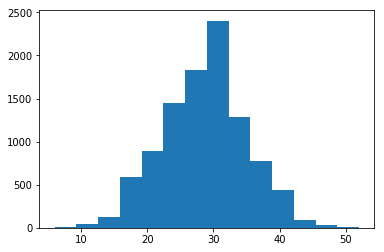

In [47]:
# Histogram of the number of cellular divisions before senescence
plt.hist(T_final, bins=14)
plt.show()

In [48]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
# In [1], they find 0.24 +- 0.04
print(np.std(T_final)/np.mean(T_final))

0.220152599912


### Symetric model -  random initialization ('independent founder cell')

In [43]:
n_exp = 10000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    list_lengths = [initialisation_from_distr() for k in range(32)]
    longueur = min(list_lengths)
    T_final.append(int((longueur-length_senescence)/3.75)+1)

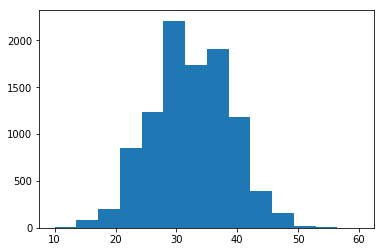

In [44]:
# Histogram of the number of cellular divisions before senescence
plt.hist(T_final, bins=14)
plt.show()

In [45]:
# Coefficient of variation for single founder cell, asymmetric telomere replication model
# In [1], they find 0.20 +- 0.03
print(np.std(T_final)/np.mean(T_final))

0.199568051864


# Verification of useful facts for theoretical analysis

In [43]:
def simple_evolution(longueur):
    x = npr.rand()
    if x > 0.5:
        return longueur + npr.randint(5, 11)
    return longueur

In [91]:
a = 240         # for instance, not too far from the biological value

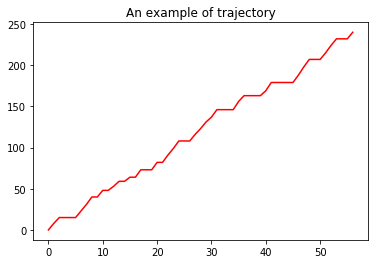

In [92]:
# An example of trajectory
T = 0
longueur = 0
L = [longueur]
while longueur < a:
    T += 1
    longueur = simple_evolution(longueur)
    L.append(longueur)
plt.plot(range(T+1), L, color='red')
plt.title('An example of trajectory')
plt.show()

Check that the walk is uniformely distributed, given that it's between $a-10$ and $a-1$, for $a >> 1$:

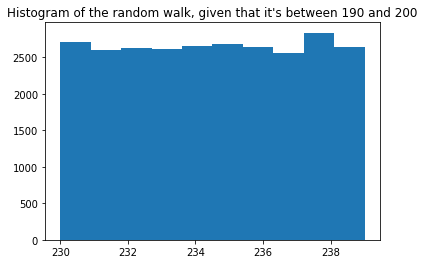

In [93]:
n_exp = 10000
L_select = []
longueur = 0
L = [longueur]*n_exp
L_finales = []
for T in range(100):
    for exp in range(n_exp):
        n = evolution_simple(L[exp])
        L[exp] = n
        if n >= a-10 and n < a:
            L_finales.append(n)
plt.hist(L_finales, bins=10)
plt.title("Histogram of the random walk, given that it's between 190 and 200")
plt.show()

Law of $S_\tau$ and independance with $\tau$:

In [94]:
# Takes a few seconds
n_exp = 10**5
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    longueur = 0
    L = [longueur]
    while longueur < a:
        T += 1
        longueur = evolution_simple(longueur)
        L.append(longueur)
    L_finales.append(L[-1])
    T_final.append(T)

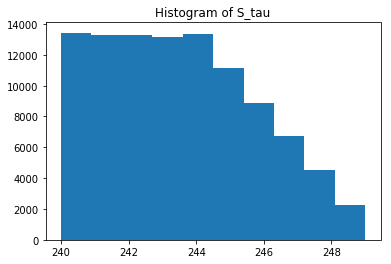

In [95]:
plt.hist(L_finales, bins=10)
plt.title('Histogram of S_tau')
plt.show()

In [96]:
# Computation of the first moments of S_tau
mean_exp = np.mean(L_finales)
mean_th = a + 31./9
print('Experimental mean: ' + str(mean_exp))
print('Theoretical mean: ' + str(mean_th))
print('Relative error: ' + str(abs((mean_exp - mean_th))/mean_th))

mean_sq_exp = np.mean(np.array(L_finales)**2)
mean_sq_th = a**2 + 62./9 * a + 161./9
print('Experimental mean of the square: ' + str(mean_sq_exp))
print('Theoretical mean of the square: ' + str(mean_sq_th))
print('Relative error: ' + str(abs((mean_sq_exp - mean_sq_th))/mean_sq_th))

Experimental mean: 243.45071
Theoretical mean: 243.44444444444446
Relative error: 2.5737106344e-05
Experimental mean of the square: 59274.30639
Theoretical mean of the square: 59271.222222222226
Relative error: 5.20348267193e-05


In [97]:
# cov(L_finales, T_final) is neglectible compared to var(T_final). Thus we neglect this term in future computations.
np.cov(L_finales, T_final)

array([[  6.05825108,   1.3963273 ],
       [  1.3963273 ,  72.03700385]])

Law of $\tau$:

In [98]:
# Computation of the first moments of tau
mean_exp = np.mean(T_final)
mean_th = 4./15 * a + 124./135
print('Experimental mean: ' + str(mean_exp))
print('Theoretical mean: ' + str(mean_th))
print('Relative error: ' + str(abs((mean_exp - mean_th))/mean_th))

mean_sq_exp = np.mean(np.array(T_final)**2)
mean_sq_th = (4./15)**2*(a**2+11.02*a + 20.1)
print('Experimental mean of the square: ' + str(mean_sq_exp))
print('Theoretical mean of the square: ' + str(mean_sq_th))
print('Relative error: ' + str(abs((mean_sq_exp - mean_sq_th))/mean_sq_th))

Experimental mean: 64.95797
Theoretical mean: 64.91851851851852
Relative error: 0.000607707667732
Experimental mean of the square: 4291.57415
Theoretical mean of the square: 4285.504
Relative error: 0.00141643783322


In [105]:
# Theoretical coefficient of variation
np.sqrt((mean_sq_th - mean_th**2))/mean_th

0.1298779766687071